# Dependencies

In [1]:
import nrrd
import slicerio as si
import os
from tkinter import filedialog
import matplotlib.pyplot as plt
import numpy as np
import med_dataloader as mdl
import tensorflow as tf
import numpy as np

# Segmentations Check

In [2]:
dataset_dir = os.path.join(os.getcwd(), "Dataset")
segmentation_dir = os.path.join(dataset_dir , "Segmentation") #mettere dataset nella working directory
segmentation_checked_dir = os.path.join(dataset_dir , "Segmentation_checked")

try:
    os.mkdir(segmentation_checked_dir)
except:
    pass


## Check

In [3]:

input_filenames = os.listdir(segmentation_dir)
segment_list = [("LL", 5), ("SP", 3), ("TO", 4), ("UL", 1), ("HE", 6), ("HP", 2)]

seg = 0

for segmentation in input_filenames:
    input_filename = os.path.join(segmentation_dir, input_filenames[seg])
    output_filename = os.path.join(segmentation_checked_dir, input_filenames[seg])
    seg = seg + 1
    voxels, header = nrrd.read(input_filename)
    segmentation_info = si.read_segmentation_info(input_filename)
    output_voxels, output_header = si.extract_segments(voxels, header, segmentation_info, segment_list)
    output_voxels = output_voxels.astype("uint8") #necessario per avere un nnrd in output con type 'uint8' anzichè 'float64' non gestito da med_dataloader
    nrrd.write(output_filename, output_voxels, output_header)


## Mac os Compatibility

In [8]:
try:
    os.system("rm" , os.path.join(segmentation_checked_dir, ".DS_Store"))
except BaseException:
    pass

In [22]:
print(len(input_filenames))
output_filenames = os.listdir(segmentation_checked_dir)
print(len(output_filenames))

460
460


## Control Plotting
* Display a comparison between original segmentation and segmentation checked

In [ ]:
seg = 0

for segmentation in  input_filenames:
    input_filename = os.path.join(segmentation_dir, input_filenames[seg])
    output_filename = os.path.join(segmentation_checked_dir, input_filenames[seg])
    seg = seg + 1
    voxels, header = nrrd.read(input_filename)
    output_voxels, header = nrrd.read(output_filename)

    fig = plt.figure(figsize = [45, 15])
    plt.subplot(1, 2, 1)
    plt.imshow(voxels[:,:,0], cmap="magma")
    plt.subplot(1, 2, 2)
    plt.imshow(output_voxels[:,:,0], cmap="magma")
    plt.show(fig)
    

# Dataloader

In [4]:
NUM_CLASSES = 7

In [5]:
mdl.generate_dataset(data_dir= os.path.join(os.getcwd(), "Dataset"),
                        imgA_label="Images",
                        imgB_label="Segmentation_checked",
                        input_size=256,
                        is_B_categorical=True,
                        num_classes = NUM_CLASSES,
                        norm_boundsA=[0,130.89391984], #normalizza tra 0 e 1; bisogna mettere lower_bound,upper_bound dell'immagine corrente!!! (non i limiti che si vogliono raggiungere)
                        norm_boundsB=None,
                        )

Caching decoded images in c:\Users\matte\Desktop\Network-Vocal_Tract_Segmentation\Dataset_TF\Images.cache...
970/970
Cached decoded images in c:\Users\matte\Desktop\Network-Vocal_Tract_Segmentation\Dataset_TF\Images.cache.
Caching decoded images in c:\Users\matte\Desktop\Network-Vocal_Tract_Segmentation\Dataset_TF\Segmentation_checked.cache...
970/970
Cached decoded images in c:\Users\matte\Desktop\Network-Vocal_Tract_Segmentation\Dataset_TF\Segmentation_checked.cache.


# LOO-CV

In [86]:
from os import walk
import shutil
import csv

K = 1
Fold = [1, 2, 3, 4, 5] #inserire una lista dei soggetti

loocv_dir = os.path.join(os.getcwd(), "LOOCV")
try:
    os.mkdir(loocv_dir)
except:
    pass

with open(os.path.join(loocv_dir, 'LOOCV_distribution.csv'), mode = 'w') as output:
            writer = csv.writer(output)
            header = ['Dataset division', 'Train images samples', 'Train segmentations samples', 'Test images samples', 'Test segmentations samples']
            writer.writerow(header)

for s in Fold: 

    images = []
    segmentations = []
    k_images = []
    k_segmentations = []
    fold_images = []
    fold_segmentations = []

    for (dirpath, dirnames, filenames) in walk(os.path.join(dataset_dir, 'Images')):
        images.extend(filenames)
        break
    for (dirpath, dirnames, filenames) in walk(os.path.join(dataset_dir, 'Segmentation_checked')): #le pesco già controllate
        segmentations.extend(filenames)
        break

    k_subj = str(s)
    fold_subjs = ''.join(map(str, Fold))
    fold_subjs = fold_subjs.replace(k_subj, '')

    fold_dir = os.path.join(loocv_dir, 'Fold_0{}'.format(s))

    try:
        os.mkdir(fold_dir)
    except:
        pass

    train_dataset_dir = os.path.join(fold_dir, 'Dataset_s{}'.format(fold_subjs))
    test_dataset_dir = os.path.join(fold_dir, 'Dataset_s{}'.format(k_subj))

    try:
        os.mkdir(train_dataset_dir)
    except:
        pass
    try:
        os.mkdir(test_dataset_dir)
    except:
        pass

    train_dataset_images = os.path.join(train_dataset_dir, 'Images')
    train_dataset_segmentations = os.path.join(train_dataset_dir, 'Segmentation')
    test_dataset_images = os.path.join(test_dataset_dir, 'Images')
    test_dataset_segmentations = os.path.join(test_dataset_dir, 'Segmentation')

    try:
        os.mkdir(train_dataset_images)
    except:
        pass
    try:
        os.mkdir(train_dataset_segmentations)
    except:
        pass
    try:
        os.mkdir(test_dataset_images)
    except:
        pass
    try:
        os.mkdir(test_dataset_segmentations)
    except:
        pass


    for i in images:
        if i.startswith('s0000{}'.format(s)):
            k_images.append(i)
    
    fold_images = list(set(images) - set(k_images))
    
    for i in segmentations:
        if i.startswith('s0000{}'.format(s)):
            k_segmentations.append(i)
    
    fold_segmentations = list(set(segmentations) - set(k_segmentations))

    print(len(k_images))
    print(len(k_segmentations))
    print(len(fold_images))
    print(len(fold_segmentations))

    with open(os.path.join(loocv_dir, 'LOOCV_distribution.csv'), mode = 'a') as output:
                writer = csv.writer(output)
                test = [ fold_subjs + '-->' + k_subj , len(fold_images), len(fold_segmentations), len(k_images), len(k_segmentations) ]
                writer.writerow(test)

    for img in fold_images:
        original = os.path.join(dataset_dir, 'Images', img)
        target = os.path.join(train_dataset_images, img)
        shutil.copyfile(original, target)

    for img in fold_segmentations:
        original = os.path.join(dataset_dir, 'Segmentation_checked', img)
        target = os.path.join(train_dataset_segmentations, img)
        shutil.copyfile(original, target)

    mdl.generate_dataset(data_dir= train_dataset_dir,
                        imgA_label="Images",
                        imgB_label="Segmentation",
                        input_size=256,
                        is_B_categorical=True,
                        num_classes = NUM_CLASSES,
                        norm_boundsA=[0,130.89391984], #normalizza tra 0 e 1; bisogna mettere lower_bound,upper_bound dell'immagine corrente!!! (non i limiti che si vogliono raggiungere)
                        norm_boundsB=None,
                        )

    for img in k_images:
        original = os.path.join(dataset_dir, 'Images', img)
        target = os.path.join(test_dataset_images, img)
        shutil.copyfile(original, target)

    for img in k_segmentations:
        original = os.path.join(dataset_dir, 'Segmentation_checked', img)
        target = os.path.join(test_dataset_segmentations, img)
        shutil.copyfile(original, target)

    mdl.generate_dataset(data_dir= test_dataset_dir,
                        imgA_label="Images",
                        imgB_label="Segmentation",
                        input_size=256,
                        is_B_categorical=True,
                        num_classes = NUM_CLASSES,
                        norm_boundsA=[0,130.89391984], #normalizza tra 0 e 1; bisogna mettere lower_bound,upper_bound dell'immagine corrente!!! (non i limiti che si vogliono raggiungere)
                        norm_boundsB=None,
                        )   


280
280
690
690
Caching decoded images in c:\Users\matte\Desktop\Network-Vocal_Tract_Segmentation\LOOCV\Fold_01\Dataset_s2345_TF\Images.cache...
690/690
Cached decoded images in c:\Users\matte\Desktop\Network-Vocal_Tract_Segmentation\LOOCV\Fold_01\Dataset_s2345_TF\Images.cache.
Caching decoded images in c:\Users\matte\Desktop\Network-Vocal_Tract_Segmentation\LOOCV\Fold_01\Dataset_s2345_TF\Segmentation.cache...
690/690
Cached decoded images in c:\Users\matte\Desktop\Network-Vocal_Tract_Segmentation\LOOCV\Fold_01\Dataset_s2345_TF\Segmentation.cache.
Caching decoded images in c:\Users\matte\Desktop\Network-Vocal_Tract_Segmentation\LOOCV\Fold_01\Dataset_s1_TF\Images.cache...
280/280
Cached decoded images in c:\Users\matte\Desktop\Network-Vocal_Tract_Segmentation\LOOCV\Fold_01\Dataset_s1_TF\Images.cache.
Caching decoded images in c:\Users\matte\Desktop\Network-Vocal_Tract_Segmentation\LOOCV\Fold_01\Dataset_s1_TF\Segmentation.cache...
280/280
Cached decoded images in c:\Users\matte\Desktop\N

# Utils

In [ ]:

max = 0
min = 255
for batch in train_ds.take(93): #meno hc
    volume_batch, label_batch = batch
    for i in range(4): #meno hc
        max_start = np.max(volume_batch[i,:,:])
        min_start = np.min(volume_batch[i,:,:])
        if max_start > max:
            max = max_start
        if min_start < min:
            min = min_start

#print(np.shape(volume_batch))
print(max, min)

In [14]:
NUM_CLASSES = 7
BATCH_SIZE = 8
EPOCHS = 70

DATA_AUGMENTATION = False
ROTATION = False
FLIP = False
CROP_SIZE = None

PERC_TRAIN_DATA = 0.8  
PERC_VALIDATION_DATA = 0.1
PERC_TEST_DATA = 0.1


#METRICS PARAMETERS
##GCE
GCE_THRESHOLD = 0.8

#LOSS PARAMETERS
##Focal
GAMMA = 2

##TopK
PERCENTILE = 5

##HD
ALPHA = 2


In [22]:
train_ds, validation_ds, test_ds = mdl.get_dataset(data_dir = os.path.join(os.getcwd(), "Dataset_TF"),
                                                    percentages = [PERC_TRAIN_DATA, PERC_VALIDATION_DATA, PERC_TEST_DATA],
                                                    batch_size = BATCH_SIZE,
                                                    train_augmentation = DATA_AUGMENTATION,
                                                    random_crop_size = CROP_SIZE,
                                                    random_rotate = ROTATION,
                                                    random_flip = FLIP,
                                                    )

In [24]:
element = 0
for i in train_ds.as_numpy_iterator():
    element += 1

BATCH_NUM_TRAIN = element

element = 0
for i in test_ds.as_numpy_iterator():
    element += 1

BATCH_NUM_TEST = element

element = 0
for i in validation_ds.as_numpy_iterator():
    element += 1

BATCH_NUM_VALIDATION = element

  Batch n°:   0


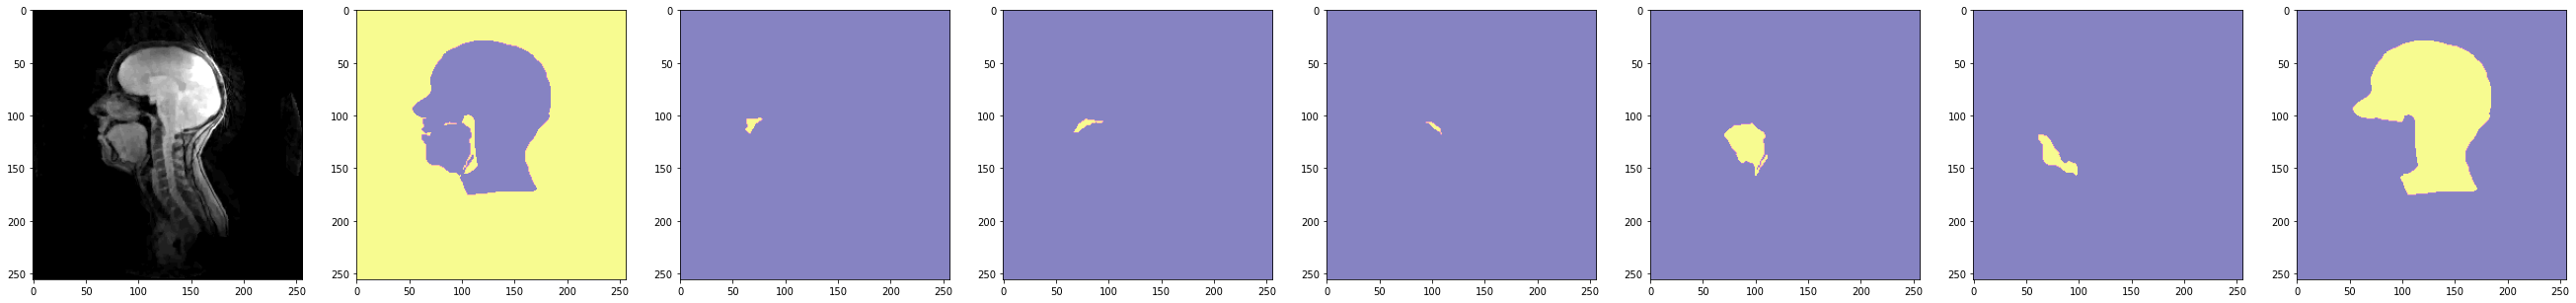

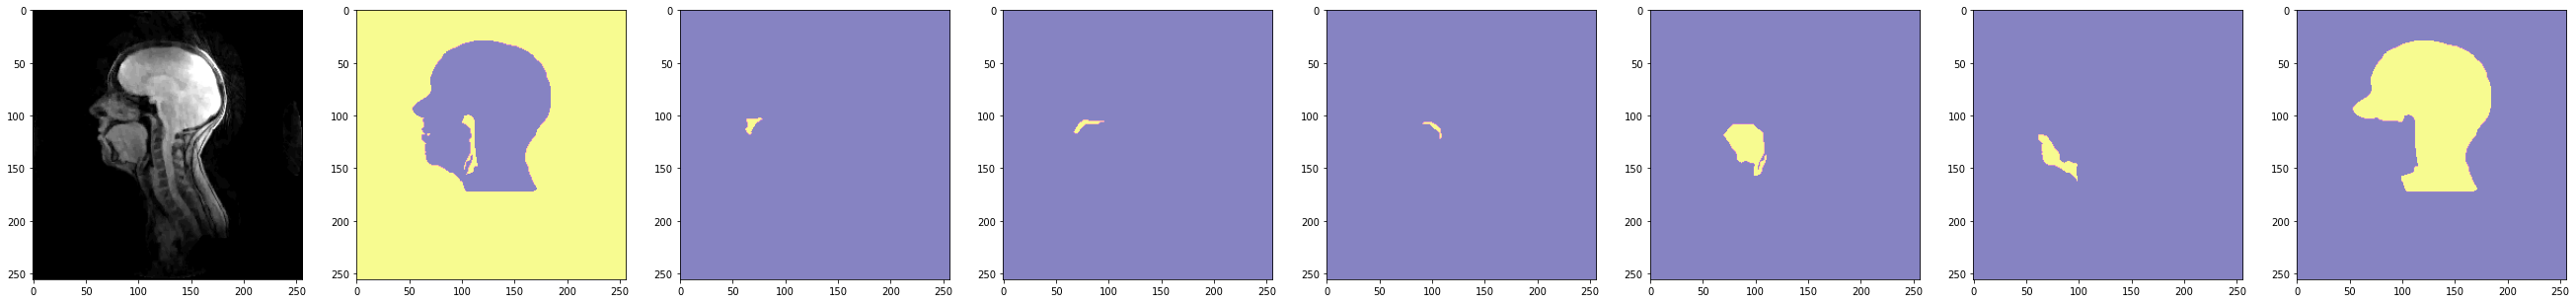

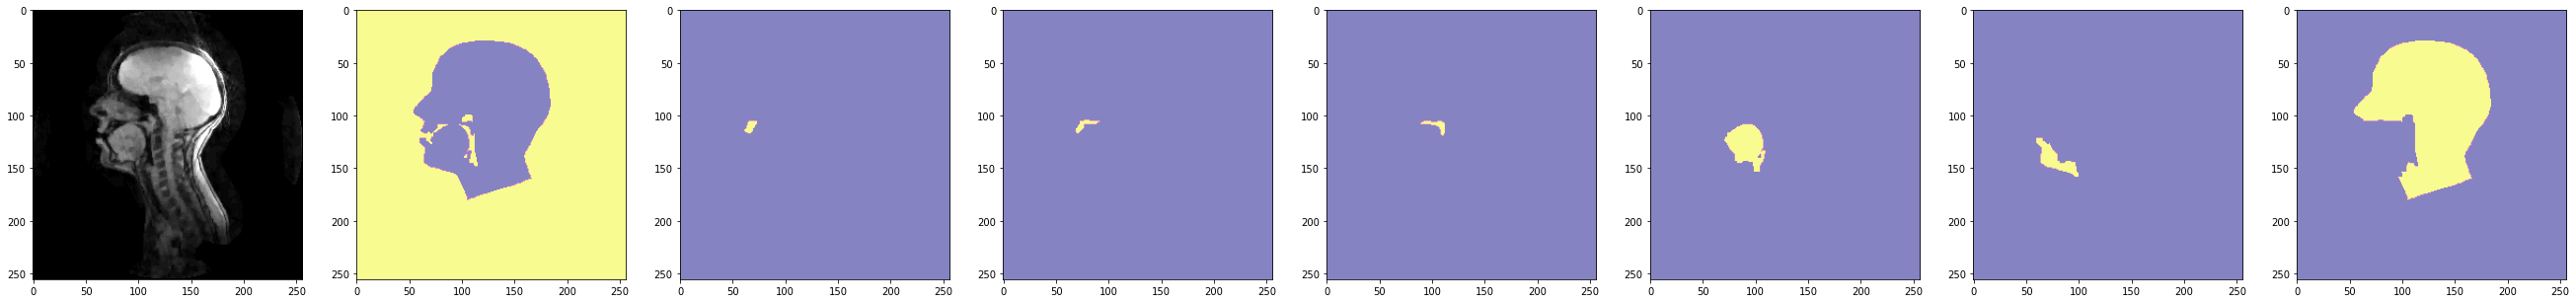

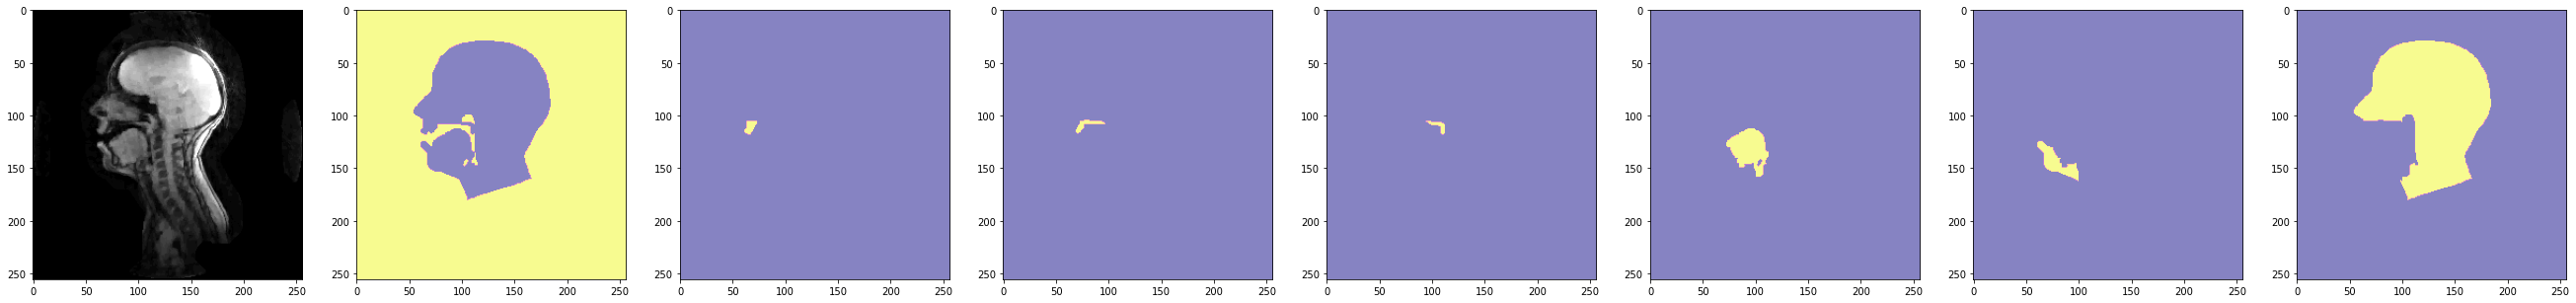

KeyboardInterrupt: 

In [30]:
batch_n = 0

for batch in train_ds.take(BATCH_NUM_TRAIN):  #rendi meno hard code 
    volume_batch, label_batch = batch
    #fig = plt.figure(figsize = [23, 7])
    
    print("\033[92m \033[1m Batch n°:  \033[0m", batch_n)
    batch_n = batch_n + 1


    for volume, label in zip(volume_batch, label_batch):
        #print(np.percentile(volume, [25, 50, 75, 90, 99]))
        fig = plt.figure(figsize = [46, 14]) #creo ogni ciclo la figura bianca
        plt.subplot(1, NUM_CLASSES + 1, 1) #creo le colonne e le righe
        plt.imshow(volume[:,:,0], cmap="gray") #ploto l'immagine

        for i in range(NUM_CLASSES):
            
            plt.subplot(1, NUM_CLASSES + 1, i+2) #muovo l'indice di colonna per plottare le varie classi 
            plt.imshow(label[:,:,i], cmap="plasma", alpha=0.5) #plotto le classi 
    plt.show(fig) #stampo il tutto